CS6140 Final Project
# Recognizing Handwritten Digits Utilizing Computer Vision Approach

The problem revolves around building an image classification model to recognize handwritten
digits, a common task in computer vision. The dataset consists of images of handwritten digits, and the
goal is to classify these images into one of 10 digit categories (0-9). This task involves extracting
meaningful features from the images and building a model to generalize well to unseen data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from torchvision import transforms

# Set random seed for reproducibility
np.random.seed(2)
torch.manual_seed(2)

# Data Preparation

### Load the data

In [ ]:
# Load the data
train = pd.read_csv("./train.csv")

In [ ]:
# Prepare labels
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels=["label"], axis=1)
# del train  # Free some space

### Label Distribution Analysis
Analyze the distribution of labels in the MNIST handwritten digit dataset, specifically the training labels (Y_train). By using Y_train.value_counts(), it counts the number of occurrences for each digit (0 through 9). The output shows that each digit has an approximately equal number of samples, which means the dataset is balanced.

In [ ]:
# Visualize the label distribution

# print(Y_train.value_counts())

# Y_train.value_counts().sort_index().plot(kind='bar', color='skyblue')
# plt.title("Distribution of Labels")
# plt.xlabel("Label")
# plt.ylabel("Count")
# plt.show()

### One-Hot Encoding
The labels from the MNIST dataset, which represent digits (0 to 9), are first converted into a tensor format using PyTorch's torch.from_numpy method. Each label is then transformed into a one-hot encoded vector using torch.nn.functional.one_hot, with the num_classes parameter set to 10. For example, the label 2 is represented as [0,0,1,0,0,0,0,0,0,0], where the position of 1 corresponds to the digit value.

In [ ]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train_tensor = torch.from_numpy(Y_train.values).long()
Y_train_one_hot = torch.nn.functional.one_hot(Y_train_tensor, num_classes=10)

### Normalization

In [ ]:
# Normalize the data and reshape for PyTorch
X_train = X_train / 255.0

### Reshaping

tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])


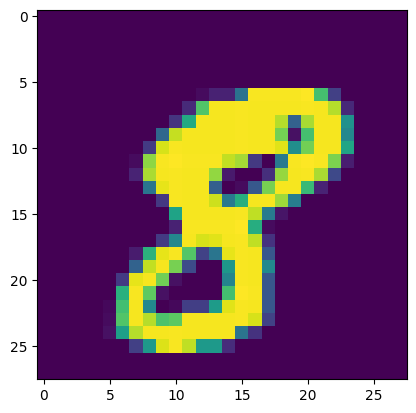

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px, channel = 1)
X_train_reshape = X_train.values.reshape(-1, 28, 28, 1)

plt.imshow(X_train_reshape[10][:,:,0])
print(Y_train_one_hot[10])

### Transform to Dataloader

In [ ]:
# Custom Dataset class for PyTorch
class MNISTDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = torch.tensor(images, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.view(1, 28, 28)  # Reshape to (1, 28, 28)
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            return image, self.labels[idx]
        return image

random_seed = 42
# Split data into training and validation sets
train_data, val_data, train_label, val_label = train_test_split(X_train_reshape, Y_train_one_hot, test_size=0.1, random_state=random_seed)

# Create PyTorch datasets
train_dataset = MNISTDataset(train_data, train_label)
val_dataset = MNISTDataset(val_data, val_label)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


<ipython-input-74-4a2b12dbaa2f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None


# Convolutional Neural Network(CNN) Model

### Define the Model


In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # First Convolutional Block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)  # Conv2D(filters=32, kernel_size=5, padding='Same')
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2) # Second Conv2D in the first block
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)       # MaxPooling
        self.dropout1 = nn.Dropout(0.25)                        # Dropout

        # Second Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # Conv2D(filters=64, kernel_size=3, padding='Same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # Second Conv2D in the second block
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)       # MaxPooling
        self.dropout2 = nn.Dropout(0.25)                        # Dropout

        # Fully Connected Layers
        self.flatten = nn.Flatten()                             # Flatten
        self.fc1 = nn.Linear(64 * 7 * 7, 256)                   # Dense(256)
        self.dropout3 = nn.Dropout(0.5)                         # Dropout
        self.fc2 = nn.Linear(256, 10)                           # Dense(10)

    def forward(self, x):
        # First Convolutional Block
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second Convolutional Block
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)

        # Fully Connected Layers
        x = self.flatten(x)               # Flatten the feature map
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = self.fc2(x)                   # Output logits (no softmax)
        return x

### Train the Model

In [ ]:
# Instantiate the model, define the loss function and optimizer
cnn_model = CNNModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(cnn_model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer,
                              mode='max',       # Use 'max' for metrics like accuracy; use 'min' for loss
                              factor=0.5,       # Reduce the learning rate by this factor (e.g., half it)
                              patience=2,       # Number of epochs with no improvement before reducing LR
                              verbose=True,     # Print a message when the LR is reduced
                              min_lr=1e-5)      # Set a lower bound on the learning rate

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(train_loader)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Validation

In [ ]:
# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float())
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            # Convert predicted index to one-hot encoding (same size as the labels)
            predicted_one_hot = torch.nn.functional.one_hot(predicted, num_classes=10).float()

            # Compare predicted one-hot with true labels
            correct += (predicted_one_hot == labels).all(dim=1).sum().item()
    val_loss /= len(val_loader)
    accuracy = 100 * correct / len(val_loader.dataset)
    return val_loss, accuracy


### Tune the Hyperparameters

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

# Training loop
num_epochs = 7

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(cnn_model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(cnn_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    scheduler.step(val_accuracy)

Epoch 1/7, Train Loss: 0.1076, Val Loss: 0.0164, Val Accuracy: 97.31%
Epoch 2/7, Train Loss: 0.0227, Val Loss: 0.0110, Val Accuracy: 98.21%
Epoch 3/7, Train Loss: 0.0163, Val Loss: 0.0094, Val Accuracy: 98.60%
Epoch 4/7, Train Loss: 0.0134, Val Loss: 0.0074, Val Accuracy: 98.98%
Epoch 5/7, Train Loss: 0.0114, Val Loss: 0.0096, Val Accuracy: 98.60%
Epoch 6/7, Train Loss: 0.0098, Val Loss: 0.0067, Val Accuracy: 98.93%
Epoch 7/7, Train Loss: 0.0090, Val Loss: 0.0058, Val Accuracy: 99.10%


### Training and Validation Visualization

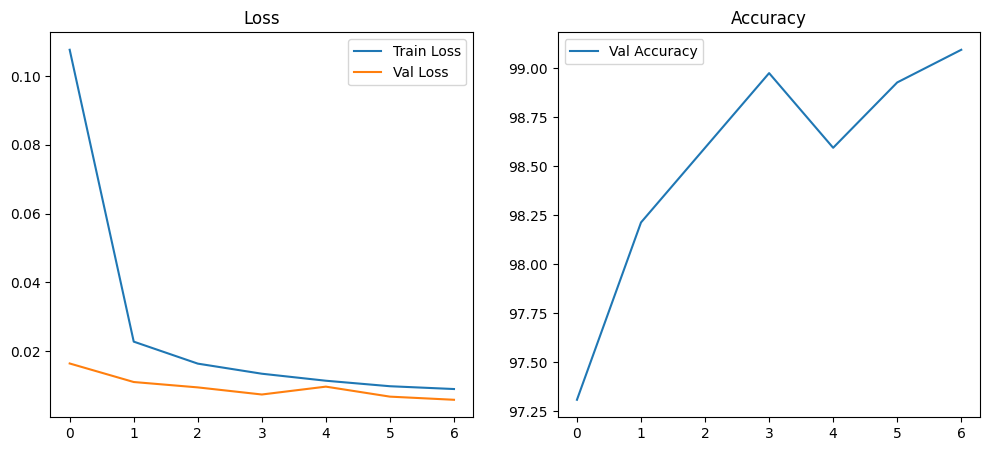

In [ ]:
# Plot losses and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Confusion Matrix

In [ ]:
import torchvision.datasets as datasets
from sklearn.metrics import classification_report

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

X_test = mnist_testset.data.numpy()
Y_test = mnist_testset.targets.numpy()

# Normalize the data and reshape for PyTorch
X_test = X_test / 255.0
# Reshape image in 3 dimensions (height = 28px, width = 28px, channel = 1)
X_test_reshape = X_test.reshape(-1, 28, 28, 1)
# plt.imshow(X_test_reshape[0][:,:,0])

# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_test_tensor = torch.from_numpy(Y_test).long()
Y_test_one_hot = torch.nn.functional.one_hot(Y_test_tensor, num_classes=10)
# print(Y_test_one_hot[0])

# Create PyTorch datasets
test_dataset = MNISTDataset(X_test_reshape, Y_test_one_hot)

# Data loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<ipython-input-74-4a2b12dbaa2f>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None


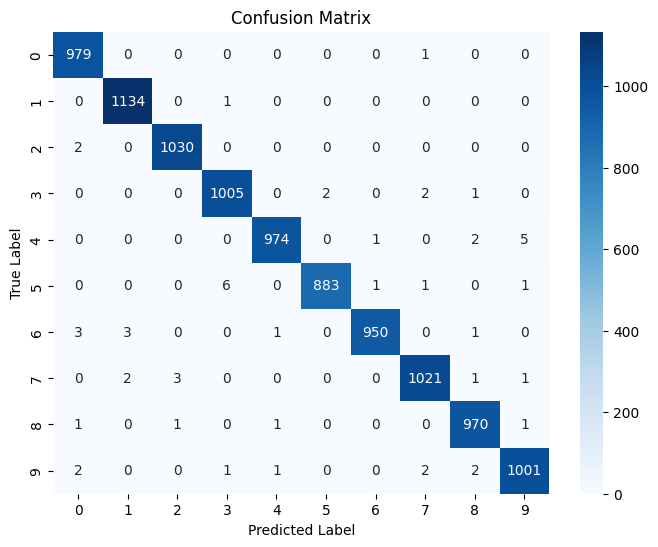

Test Accuracy: 99.47%


In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Step 1: Predict the classes using the PyTorch model
cnn_model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:  # Iterate through test data loader
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        _, preds = torch.max(outputs, 1)  # Get the class index with the highest score

        # Convert true labels from one-hot encoding to class indices if necessary
        if len(labels.shape) > 1:  # If labels are one-hot encoded
            labels = torch.argmax(labels, dim=1)

        all_preds.extend(preds.cpu().numpy())  # Append predictions
        all_labels.extend(labels.cpu().numpy())  # Append true labels

# Step 2: Compute the confusion matrix
classes = list(range(10))  # Update this list for your dataset if needed
confusion_mtx = confusion_matrix(all_labels, all_preds)

# Step 3: Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=classes, title="Confusion Matrix")

test_loss, test_accuracy = validate(cnn_model, test_loader, criterion, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=[f"{i}" for i in classes]))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       1.00      0.99      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

